# Predicting Time to Adoption in Animal Shelters using Survival Analysis

## Introduction
- This project applies survival analysis to explore time-to-adoption of animals in a shelter.
- The goal is to understand factors that influence how quickly animals are adopted.
- Techniques used: Kaplan-Meier Estimator, Cox Proportional Hazards Model.


The goal of this project is to apply survival analysis techniques to understand the factors that influence how long animals stay in shelters before being adopted. By modeling time-to-adoption using tools like Kaplan-Meier estimators and the Cox Proportional Hazards model, we aim to identify key traits (such as age, sex, intake condition, and animal type) that significantly impact adoption speed. These insights can help shelters improve their adoption strategies and reduce the time animals spend in care.



## Importing Libraries
- `pandas`, `numpy` for data handling.
- `matplotlib`, `seaborn` for visualization.
- `lifelines` for survival models.
- `sklearn` for preprocessing


In [3]:
from sklearn.preprocessing import LabelBinarizer
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\dell\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Loading the Dataset
- Load the animal shelter dataset using pandas.



The dataset used in this project comes from the Austin Animal Center, one of the largest no-kill municipal animal shelters in the United States. Two datasets were used:

Intakes Dataset: Contains information about animals when they enter the shelter, including intake date, type, condition, age, sex, and species.

Outcomes Dataset: Contains details about the animal's exit from the shelter, such as outcome type (e.g., adoption, transfer, euthanasia), date, and condition.

These datasets were merged using the Animal ID field to calculate the duration (in days) between intake and outcome. The outcome type was then used to define an event column, where adoption was considered the primary event of interest.

In [4]:
intakesData = pd.read_csv("Austin_Animal_Center_Intakes.csv")
outcomesData = pd.read_csv("Austin_Animal_Center_Outcomes.csv")

In [5]:
intakesData.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,*Brock,01/03/2019 04:19:00 PM,January 2019,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Belle,07/05/2015 12:59:00 PM,July 2015,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Runster,04/14/2016 06:43:00 PM,April 2016,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
3,A665644,NaN,10/21/2013 07:59:00 AM,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A857105,Johnny Ringo,05/12/2022 12:23:00 AM,May 2022,4404 Sarasota Drive in Austin (TX),Public Assist,Normal,Cat,Neutered Male,2 years,Domestic Shorthair,Orange Tabby


In [6]:
outcomesData.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A882831,*Hamilton,07/01/2023 06:12:00 PM,Jul 2023,03/25/2023,Adoption,NaN,Cat,Neutered Male,3 months,Domestic Shorthair Mix,Black/White
1,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
2,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
3,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
4,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff



- Merging both the datasets

In [7]:
data = pd.merge(intakesData,outcomesData,on="Animal ID",how="inner")

In [8]:
data.head()

,Animal ID,Name_x,DateTime_x,MonthYear_x,Found Location,Intake Type,Intake Condition,Animal Type_x,Sex upon Intake,Age upon Intake,...,DateTime_y,MonthYear_y,Date of Birth,Outcome Type,Outcome Subtype,Animal Type_y,Sex upon Outcome,Age upon Outcome,Breed_y,Color_y
0,A786884,*Brock,01/03/2019 04:19:00 PM,January 2019,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,2 years,...,01/08/2019 03:11:00 PM,Jan 2019,01/03/2017,Transfer,Partner,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Belle,07/05/2015 12:59:00 PM,July 2015,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,...,07/05/2015 03:13:00 PM,Jul 2015,07/05/2007,Return to Owner,NaN,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Runster,04/14/2016 06:43:00 PM,April 2016,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,11 months,...,04/21/2016 05:17:00 PM,Apr 2016,04/17/2015,Return to Owner,NaN,Dog,Neutered Male,1 year,Basenji Mix,Sable/White
3,A665644,NaN,10/21/2013 07:59:00 AM,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,...,10/21/2013 11:39:00 AM,Oct 2013,09/21/2013,Transfer,Partner,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A857105,Johnny Ringo,05/12/2022 12:23:00 AM,May 2022,4404 Sarasota Drive in Austin (TX),Public Assist,Normal,Cat,Neutered Male,2 years,...,05/12/2022 02:35:00 PM,May 2022,05/12/2020,Transfer,Partner,Cat,Neutered Male,2 years,Domestic Shorthair,Orange Tabby


## Data Cleaning & Preprocessing
- Convert date columns to datetime format.
- Calculate survival time: time until adoption or censoring.
- Create binary event indicator: 1 = adopted, 0 = not adopted.
- Handle missing values or irrelevant columns.


In [9]:
cols = ['Breed_y', 'Color_y', 'Name_y','Animal Type_y']
data.drop(cols,inplace=True,axis=1)

In [10]:
data.rename(columns={
    'Name_x':"Name",
    'DateTime_x':"IntakeDateTime",
    'DateTime_y':"OutcomeDateTime",
    'Breed_x':"Breed",
    'Color_x':'Color',
    'MonthYear_x':"IntakeMonthYear",
    'MonthYear_y':"OutcomeMonthYear",
    'Animal Type_x':'AnimalType'
},inplace=True)

In [11]:
data.columns

Index(['Animal ID', 'Name', 'IntakeDateTime', 'IntakeMonthYear',
       'Found Location', 'Intake Type', 'Intake Condition', 'AnimalType',
       'Sex upon Intake', 'Age upon Intake', 'Breed', 'Color',
       'OutcomeDateTime', 'OutcomeMonthYear', 'Date of Birth', 'Outcome Type',
       'Outcome Subtype', 'Sex upon Outcome', 'Age upon Outcome'],
      dtype='object')

In [12]:
data.drop_duplicates(inplace=True)

In [13]:
data['IntakeDateTime'] = pd.to_datetime(data['IntakeDateTime'],format='%m/%d/%Y %I:%M:%S %p')
data['OutcomeDateTime'] = pd.to_datetime(data['OutcomeDateTime'],format='%m/%d/%Y %I:%M:%S %p')
data['Duration'] = (data['OutcomeDateTime'] - data['IntakeDateTime']).dt.days

In [14]:
def toDays(age):
    if age == 'nan' or pd.isnull(age):
        return np.nan
    
    num,unit = age.split()
    num = int(num)
    unit = unit.lower()
        
    if (num<0):
        num = abs(num)
    if 'day' in unit:
        return int(num)
    elif 'year' in unit:
        return int(num*365)
    elif 'month' in unit:
        return int(num*31)
    elif 'week' in unit:
        return int(num*7)
    else:
        return np.nan


In [15]:
def conditionGrouping(condition):
    if condition in ['Normal']:
        return 'Normal'
    elif condition in ['Sick', 'Injured', 'Pregnant', 'Aged', 'Nursing']:
        return 'Moderate Medical'
    elif condition in ['Neonatal', 'Med Attn', 'Medical', 'Med Urgent', 'Parvo', 'Neurologic', 'Panleuk', 'Congenital', 'Agonal']:
        return 'Critical Medical'
    elif condition in ['Behavior', 'Feral']:
        return 'Behavioral'
    elif condition in ['Unknown', 'Other', 'Space']:
        return 'Other'
    else:
        return 'Other'
data['Condition Group'] = data['Intake Condition'].apply(conditionGrouping)

In [16]:
data = data[data['Duration'] >= 0]

In [17]:
data['Age_days_upon_Intake'] = data['Age upon Intake'].apply(toDays)
data['Age_days_upon_Outcome'] = data['Age upon Outcome'].apply(toDays)

In [18]:
data.isna().sum()

Animal ID                     0
Name                      49458
IntakeDateTime                0
IntakeMonthYear               0
Found Location                0
Intake Type                   0
Intake Condition              0
AnimalType                    0
Sex upon Intake               2
Age upon Intake               1
Breed                         0
Color                         0
OutcomeDateTime               0
OutcomeMonthYear              0
Date of Birth                 0
Outcome Type                 54
Outcome Subtype          111503
Sex upon Outcome              2
Age upon Outcome              5
Duration                      0
Condition Group               0
Age_days_upon_Intake          1
Age_days_upon_Outcome         5
dtype: int64

In [19]:
data['Name'] = data['Name'].fillna('Not Specified')
data['Sex upon Intake'] = data['Sex upon Intake'].fillna('Unknown')
data['Outcome Type'] = data['Outcome Type'].fillna('Not Specified')
data['Outcome Subtype'] = data['Outcome Subtype'].fillna('Not Specified')
data['Sex upon Outcome'] = data['Sex upon Outcome'].fillna('Unknown')

In [20]:
lb = LabelBinarizer()
encoded = lb.fit_transform(data['Outcome Type'])

In [21]:
lb.classes_

array(['Adoption', 'Died', 'Disposal', 'Euthanasia', 'Lost', 'Missing',
       'Not Specified', 'Relocate', 'Return to Owner', 'Rto-Adopt',
       'Stolen', 'Transfer'], dtype='<U15')

In [22]:
data['isAdopted'] = encoded[:,list(lb.classes_).index('Adoption')]

In [23]:
data['IntakeYear'] = data['IntakeDateTime'].dt.year
data['IntakeMonth'] = data['IntakeDateTime'].dt.strftime('%b')

In [24]:
data['OutcomeYear'] = data['OutcomeDateTime'].dt.year
data['OutcomeMonth'] = data['OutcomeDateTime'].dt.strftime('%b')

## Exploratory Data Analysis (EDA)
- Distribution of adoption time.
- Counts by animal type, breed, sterilization status, etc.
- Relationship between features and adoption status.


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195405 entries, 0 to 220354
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Animal ID              195405 non-null  object        
 1   Name                   195405 non-null  object        
 2   IntakeDateTime         195405 non-null  datetime64[ns]
 3   IntakeMonthYear        195405 non-null  object        
 4   Found Location         195405 non-null  object        
 5   Intake Type            195405 non-null  object        
 6   Intake Condition       195405 non-null  object        
 7   AnimalType             195405 non-null  object        
 8   Sex upon Intake        195405 non-null  object        
 9   Age upon Intake        195404 non-null  object        
 10  Breed                  195405 non-null  object        
 11  Color                  195405 non-null  object        
 12  OutcomeDateTime        195405 non-null  datetime6

In [26]:
data.describe()

,IntakeDateTime,OutcomeDateTime,Duration,Age_days_upon_Intake,Age_days_upon_Outcome,isAdopted,IntakeYear,OutcomeYear
count,195405,195405,195405.000000,195404.000000,195400.000000,195405.000000,195405.000000,195405.000000
mean,2018-09-29 07:33:13.650111488,2018-12-04 18:18:59.899900160,66.049640,726.900877,781.589585,0.487618,2018.238853,2018.414247
min,2013-10-01 07:51:00,2013-10-01 10:39:00,0.000000,0.000000,0.000000,0.000000,2013.000000,2013.000000
25%,2016-01-16 13:12:00,2016-04-04 14:00:00,2.000000,62.000000,93.000000,0.000000,2016.000000,2016.000000
50%,2018-06-01 11:26:00,2018-08-18 14:49:00,7.000000,365.000000,365.000000,0.000000,2018.000000,2018.000000
75%,2021-05-30 12:05:00,2021-07-25 19:01:00,35.000000,730.000000,1095.000000,1.000000,2021.000000,2021.000000
max,2025-04-06 10:16:00,2025-04-08 10:23:00,3883.000000,10950.000000,10950.000000,1.000000,2025.000000,2025.000000
std,NaN,NaN,224.502447,1007.021832,1037.799657,0.499848,3.197970,3.199552


In [27]:
data['isAdopted'].value_counts(normalize=True)

isAdopted
0    0.512382
1    0.487618
Name: proportion, dtype: float64

C:\Users\dell\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dell\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dell\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dell\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-

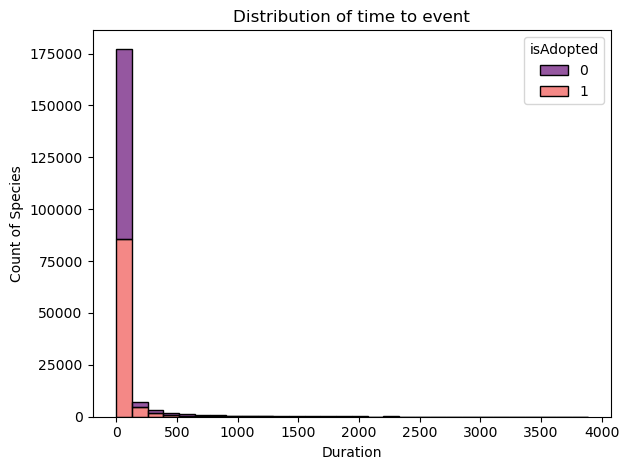

In [28]:
sns.histplot(data=data,x='Duration',bins=30,hue='isAdopted',kde=False,multiple='stack',palette='magma')
plt.title('Distribution of time to event')
plt.xlabel('Duration')
plt.ylabel('Count of Species')
plt.tight_layout()
plt.show()

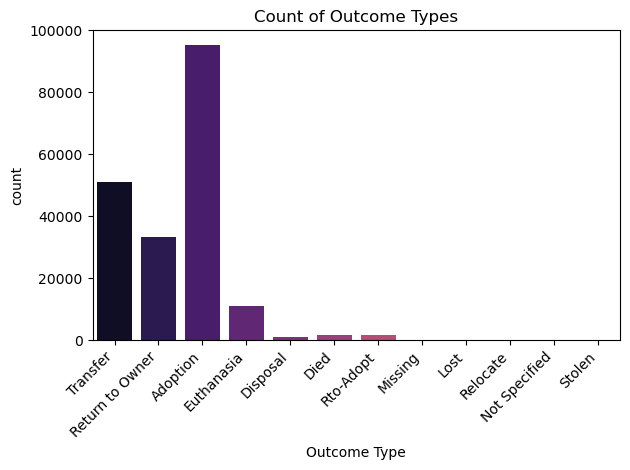

In [29]:
sns.countplot(data=data, x='Outcome Type', palette="magma")
plt.xticks(rotation=45, ha='right')
plt.title('Count of Outcome Types')
plt.tight_layout()
plt.show()

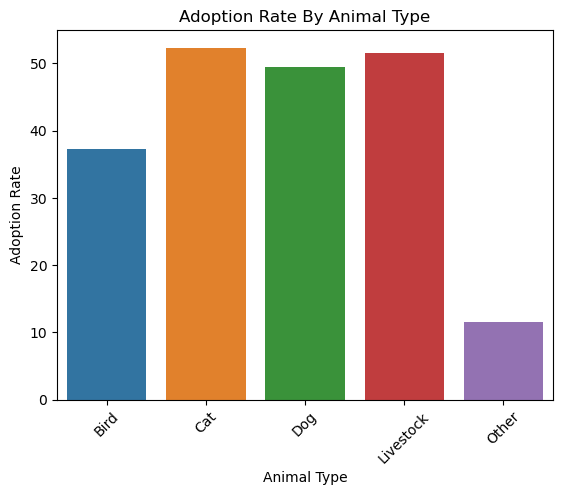

In [30]:
groupedByAnimalType = data.groupby('AnimalType')['isAdopted'].mean() * 100
grouped_df = groupedByAnimalType.reset_index()
grouped_df.columns = ['AnimalType', 'AdoptionRate']

sns.barplot(data=grouped_df,x='AnimalType',y='AdoptionRate')
plt.xticks(rotation=45)
plt.title('Adoption Rate By Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Adoption Rate')
plt.show()

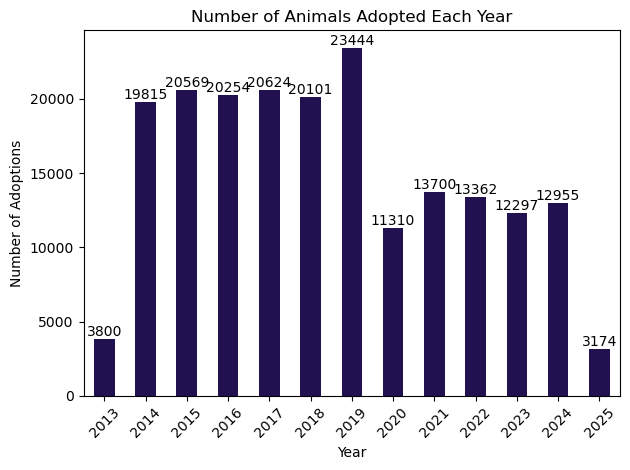

In [31]:
adopted_per_year = data.groupby('OutcomeYear').size()
sns.set_palette("magma")
ax = adopted_per_year.plot(kind='bar')

for i, v in enumerate(adopted_per_year.values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10) 
plt.title('Number of Animals Adopted Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Adoptions')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

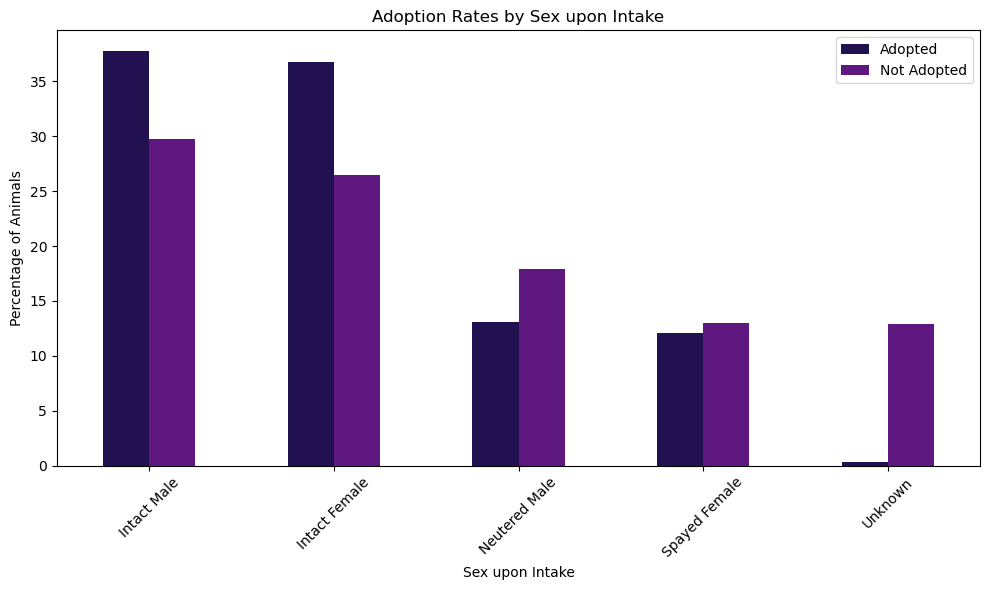

In [32]:
adopted = data[data['isAdopted'] == 1]
not_adopted = data[data['isAdopted'] == 0]

adopted_sex = adopted['Sex upon Intake'].value_counts(normalize=True) * 100
not_adopted_sex = not_adopted['Sex upon Intake'].value_counts(normalize=True) * 100

comparison_df = pd.DataFrame({
    'Adopted': adopted_sex,
    'Not Adopted': not_adopted_sex
}).fillna(0)

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Adoption Rates by Sex upon Intake')
plt.ylabel('Percentage of Animals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


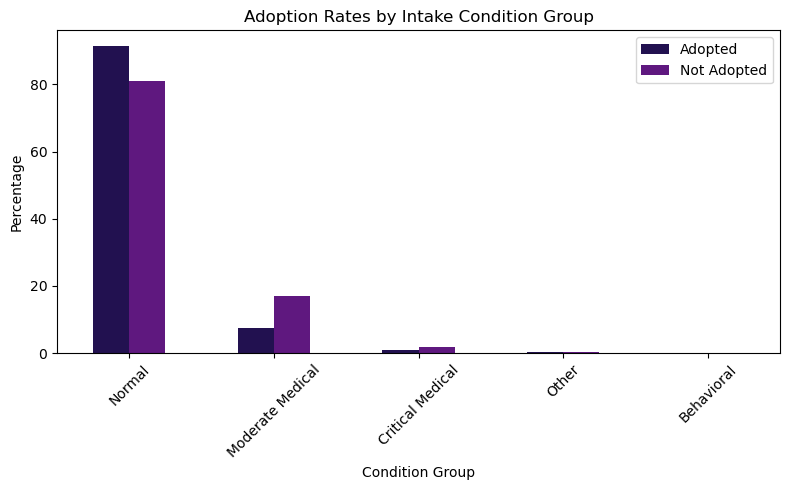

In [33]:
adopted_group = data[data['isAdopted'] == 1]['Condition Group'].value_counts(normalize=True) * 100
not_adopted_group = data[data['isAdopted'] == 0]['Condition Group'].value_counts(normalize=True) * 100

comparison = pd.DataFrame({
    'Adopted': adopted_group,
    'Not Adopted': not_adopted_group
}).fillna(0)

comparison.plot(kind='bar', figsize=(8, 5))
plt.title('Adoption Rates by Intake Condition Group')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


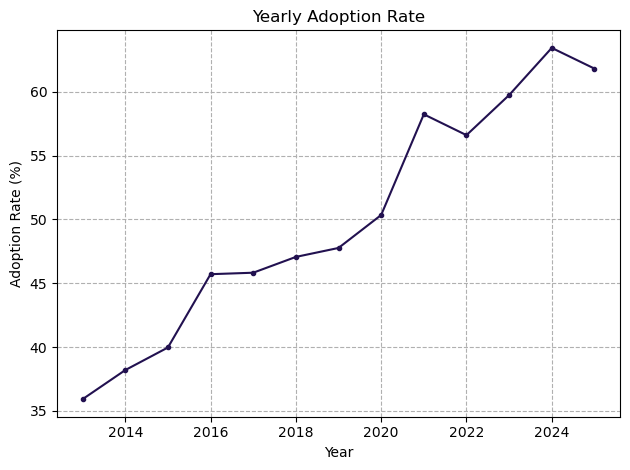

In [34]:
yearlyAdoptionRate = data.groupby('OutcomeYear')['isAdopted'].mean()*100
sns.set_palette("magma")
yearlyAdoptionRate.plot(kind='line', marker='.') 
plt.xlabel('Year')
plt.ylabel('Adoption Rate (%)')
plt.title('Yearly Adoption Rate')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

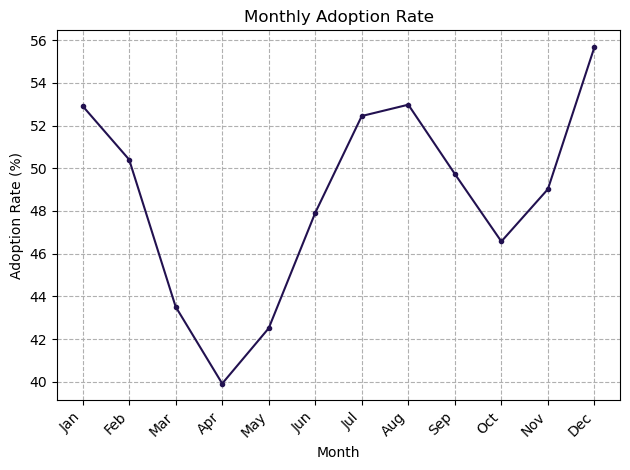

In [35]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthlyAdoptionRate = data.groupby('OutcomeMonth')['isAdopted'].mean().reindex(month_order)*100
sns.set_palette("magma")
monthlyAdoptionRate.plot(kind='line', marker='.')
plt.xlabel('Month')
plt.ylabel('Adoption Rate (%)')
plt.title('Monthly Adoption Rate')
plt.grid(True, linestyle='--')
plt.xticks(range(len(month_order)), month_order, rotation=45, ha='right') 
plt.tight_layout()
plt.show()

C:\Users\dell\anaconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


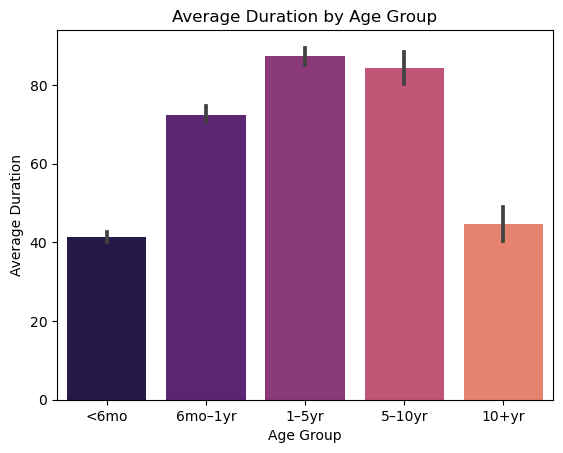

In [36]:
data['AgeGroup'] = pd.cut(data['Age_days_upon_Intake'], bins=[0, 180, 365, 1825, 3650, 10000],
                                    labels=['<6mo', '6mo–1yr', '1–5yr', '5–10yr', '10+yr'])
sns.set_palette("magma")
sns.barplot(x='AgeGroup', y='Duration', data=data)
plt.xlabel('Age Group')
plt.ylabel('Average Duration') # Emphasize that it's the mean
plt.title('Average Duration by Age Group')
plt.show()

## Kaplan-Meier Estimator
- Estimate survival probability over time.
- Plot survival curves for different groups:
  - Animal Type (Dog vs Cat)
  - Sterilization status
  - Age groups


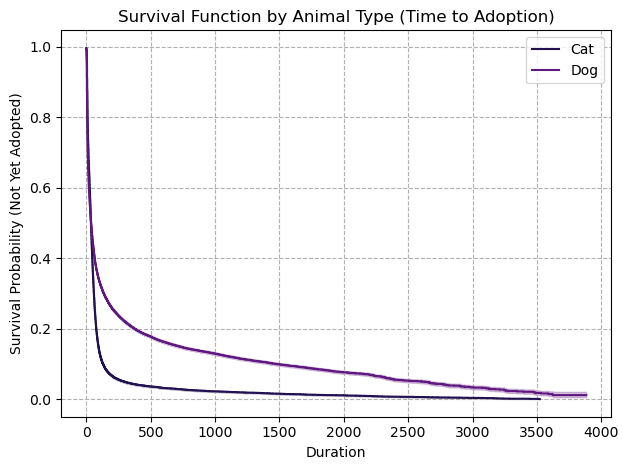

In [49]:
kmf = KaplanMeierFitter()
sns.set_palette("magma") 

for species in ['Cat', 'Dog']:
    species_data = data[data['AnimalType'] == species]
    kmf.fit(durations=species_data['Duration'], event_observed=species_data['isAdopted'] == 1, label=species)
    kmf.plot_survival_function( ci_show=True)

plt.title('Survival Function by Animal Type (Time to Adoption)')
plt.xlabel('Duration')
plt.ylabel('Survival Probability (Not Yet Adopted)')
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

Dogs tend to get adopted faster than cats, as shown by the steeper decline in the survival curve.

In [40]:
Cats = data[data['AnimalType']=='Cat']
Dogs = data[data['AnimalType']=='Dog']
logrank_test(Cats['Duration'],Dogs['Duration'],event_observed_A=Cats['isAdopted'],event_observed_B=Dogs['isAdopted'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        1838.20 <0.005       inf

## Log-Rank Test
- Compare survival distributions of different groups.
- Example: Dogs vs Cats, sterilized vs non-sterilized.


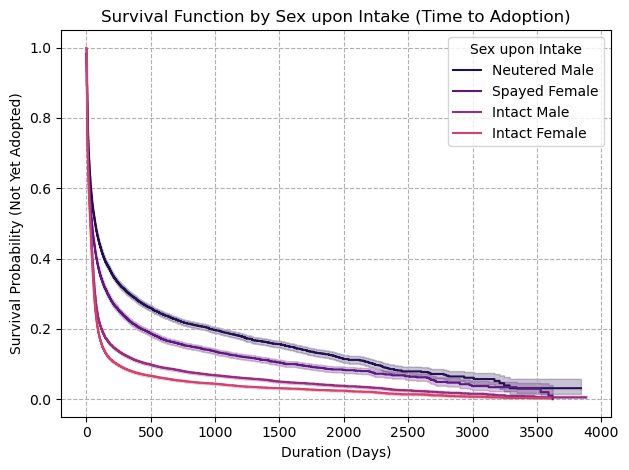

In [41]:
animals_known_sex = data[data['Sex upon Intake'].isin(['Neutered Male', 'Spayed Female', 'Intact Female', 'Intact Male'])]

kmf = KaplanMeierFitter()
sns.set_palette("magma") 

for sex in ['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female']:
    sex_data = animals_known_sex[animals_known_sex['Sex upon Intake'] == sex]
    kmf.fit(durations=sex_data['Duration'], event_observed=sex_data['isAdopted'] == 1, label=sex)
    kmf.plot_survival_function(ci_show=True)

plt.title('Survival Function by Sex upon Intake (Time to Adoption)')
plt.xlabel('Duration (Days)')
plt.ylabel('Survival Probability (Not Yet Adopted)')
plt.legend(title='Sex upon Intake') 
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

Sterilized animals had higher adoption rates, suggesting that sterilization may positively influence adoptability.

In [42]:
multivariate_logrank_test(
    event_durations=animals_known_sex['Duration'],
    groups=animals_known_sex['Sex upon Intake'],
    event_observed=animals_known_sex['isAdopted'] == 1
)


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        3502.78 <0.005       inf

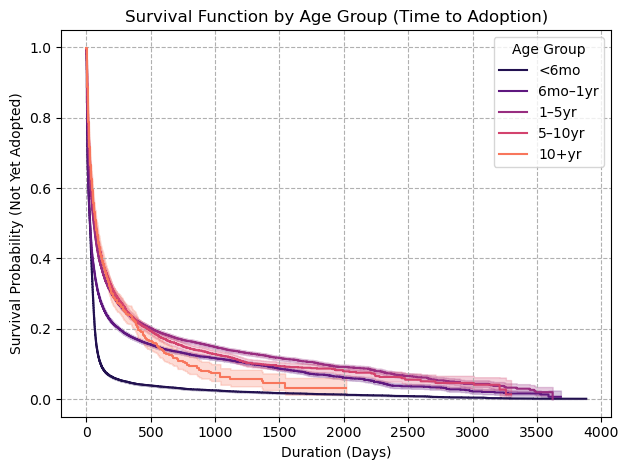

In [43]:
kmf = KaplanMeierFitter()
sns.set_palette("magma")

for age_group in ['<6mo', '6mo–1yr', '1–5yr', '5–10yr', '10+yr']:
    age_data = data[data['AgeGroup'] == age_group]
    kmf.fit(durations=age_data['Duration'], event_observed=age_data['isAdopted'] == 1, label=age_group)
    kmf.plot_survival_function(ci_show=True)

plt.title('Survival Function by Age Group (Time to Adoption)')
plt.xlabel('Duration (Days)')
plt.ylabel('Survival Probability (Not Yet Adopted)')
plt.legend(title='Age Group')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

In [44]:
multivariate_logrank_test(
    event_durations=data['Duration'],
    groups=data['AgeGroup'],
    event_observed=data['isAdopted'] == 1
)


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 5
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        8248.79 <0.005       inf

## Key Insights
- Younger animals tend to be adopted faster than older ones.
- Sterilized animals had a higher adoption rate.
- Dogs were generally adopted faster than cats in the dataset.
- Breed and intake condition (e.g., sick, stray) influenced adoption time.


## Conclusion
- Survival analysis provides meaningful insights into animal adoption patterns.
- These insights can help shelters optimize animal care and improve adoption rates.
